In [1]:
%load_ext autoreload

In [2]:
#coding=utf-8
%autoreload
import pandas as pd
import numpy as np
import os
import ujson
import csv
from tqdm import tqdm
from collections import Counter
import multiprocessing
from multiprocessing import Pool
import re
import pickle
import time
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import gc
from joblib import Parallel, delayed
from sklearn.metrics import pairwise_distances
from sklearn.manifold import TSNE
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import matplotlib
import matplotlib.colors as mcolors
from matplotlib.backends.backend_pdf import PdfPages
import json
import active_search_utilities
import preprocessing_utilities
from scipy.stats import pearsonr

In [3]:
import global_variables

In [4]:
global_variables.init()

In [5]:
domain = 'yahoo'

In [6]:
df_reviews = pd.read_csv('../yahoo_reviews_extracted.csv')

In [7]:
t_thr = df_reviews['t'].quantile(0.6)

In [8]:
df_reviews['score'] += 0.05 # to make them larger than 0

In [9]:
df_reviews_train = df_reviews[df_reviews['t'] < t_thr]

In [10]:
df_reviews_test = df_reviews[df_reviews['t'] > t_thr]

In [11]:
user_cnt_stats = df_reviews_train.groupby('user_id').size().reset_index()

In [12]:
user_cnt_stats = pd.merge(user_cnt_stats, df_reviews_test.groupby('user_id').size().reset_index(), 
                          on='user_id', how='inner')

In [13]:
user_cnt_stats.columns = ['user_id', 'train_size', 'test_size']

In [14]:
valid_users = user_cnt_stats[(user_cnt_stats['train_size'] > 500)&(user_cnt_stats['test_size'] > 100)]

In [15]:
len(valid_users)

13215

In [16]:
sample_users = valid_users['user_id'].sample(2000, random_state=1).values

In [17]:
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds

In [18]:
D = csr_matrix((df_reviews_train['score'].values/100, (df_reviews_train['user_id'].values, df_reviews_train['item_id'].values)), 
               shape=(len(df_reviews['user_id'].unique()), len(df_reviews['item_id'].unique())), dtype=float)

In [19]:
import implicit

In [ ]:
model = implicit.als.AlternatingLeastSquares(factors=10, iterations = 50)
model.fit(D.T)

In [ ]:
HFS = np.vstack([np.array(D.getrow(i).todense())  for i in sample_users.astype(int)])

In [ ]:
HFS.shape

In [ ]:
LFS = model.user_factors[sample_users.astype(int)].dot(model.item_factors.T)

In [ ]:
LFS.shape

In [ ]:
from scipy.stats import pearsonr

In [ ]:
rs = []
for i in range(len(sample_users)):
    rs.append(pearsonr(HFS[i], LFS[i])[0])
rs = np.array(rs)

In [ ]:
plt.hist(rs)

In [ ]:
ps = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 1]
stratified_users = []
np.random.seed(1)
for i in range(1, len(ps)):
    sub_inds = np.where((rs < ps[i])&(rs > ps[i - 1]))[0]
    stratified_users.extend(sample_users[np.random.choice(sub_inds, 5, replace=False)].astype(int).tolist())

In [ ]:
stratified_users = np.array(stratified_users)

In [ ]:
len(stratified_users)

In [ ]:
D_test = csr_matrix((df_reviews_test['score'].values/100, (df_reviews_test['user_id'].values, df_reviews_test['item_id'].values)), 
               shape=(len(df_reviews['user_id'].unique()), len(df_reviews['item_id'].unique())), dtype=float)

In [ ]:
HFS = np.vstack([np.array(D_test.getrow(i).todense()) for i in stratified_users.astype(int)])

In [ ]:
LFS = model.user_factors[stratified_users.astype(int)].dot(model.item_factors.T)

In [ ]:
rs = []
for i in range(len(stratified_users)):
    rs.append(pearsonr(HFS[i], LFS[i])[0])
rs = np.array(rs)

In [ ]:
plt.hist(rs, bins=20)

In [ ]:
for i in range(len(stratified_users)):
    plt.figure(figsize=(3, 3))
    plt.scatter(HFS[i], LFS[i], s=1)
    plt.title('%.4f' % pearsonr(HFS[i], LFS[i])[0])
    plt.axis('equal')

In [38]:
relevant_items = df_reviews[df_reviews['user_id'].isin(stratified_users)]['item_id'].unique()

In [41]:
Q = []
for u in stratified_users:
    seek_u_reviews = df_reviews_test[df_reviews_test['user_id'] == u]
    Q.append([seek_u_reviews['item_id'].values.astype(int).tolist(), int(u)])

In [94]:
global_variables.all_hfs = [h[relevant_items.astype(int)] for h in HFS]
global_variables.all_lfs = [h[relevant_items.astype(int)] for h in LFS]

In [95]:
global_variables.vertex_to_code = {int(relevant_items[i]):i for i in range(len(relevant_items))}
global_variables.code_to_vertex = {v:k for k, v in global_variables.vertex_to_code.items()}

In [96]:
global_variables.embedding = model.item_factors[relevant_items.astype(int)]

In [97]:
dists = pairwise_distances(global_variables.embedding)

In [98]:
global_variables.V_sims = 3*1e-2/(3*1e-2 + dists)

global_variables.V_sims = 0.5*(global_variables.V_sims + global_variables.V_sims.T)

In [100]:
from scipy.stats import pearsonr

In [101]:
np.isnan(global_variables.all_hfs[q]).any()

False

In [102]:
np.isnan(global_variables.all_lfs[q]).any()

False

In [ ]:
rs = []
for q in range(len(Q)):
    valid_inds = np.where(global_variables.all_hfs[q] > 0)[0]
    print(q, pearsonr(global_variables.all_hfs[q][valid_inds], global_variables.all_lfs[q][valid_inds]))
    rs.append(pearsonr(global_variables.all_hfs[q][valid_inds], global_variables.all_lfs[q][valid_inds])[0])

In [ ]:
plt.hist(rs)

In [ ]:
from scipy.stats import spearmanr 

rs = []
for q in range(len(Q)):
    valid_inds = np.where(global_variables.all_hfs[q] > 0)[0]
    print(q, spearmanr(global_variables.all_hfs[q][valid_inds], global_variables.all_lfs[q][valid_inds]))
    rs.append(spearmanr(global_variables.all_hfs[q][valid_inds], global_variables.all_lfs[q][valid_inds])[0])

plt.hist(rs)

np.mean(rs)

In [108]:
Lambda = min(100, np.min(np.array([len(Q[q][0]) for q in range(len(Q))])))
print(Lambda)
lambda_low = 0 # special case for counting only high fidelity steps whereas low fidelities are queried *param* times per h.f.-step
lambda_high = 1.0
INITIAL_SEED_SET_SIZES = [5]

100


In [109]:
do_randomstart = False
if do_randomstart:
    random_or_intended_start = 'randomstart'
else:
    random_or_intended_start = 'intendedstart'

In [110]:
test_params_set = []
for q in range(0, len(Q)):
    for INITIAL_SEED_SET_SIZE in INITIAL_SEED_SET_SIZES:
        test_params_set.append((q, INITIAL_SEED_SET_SIZE))

In [111]:
from copy import deepcopy
def get_backup_globals():
    return deepcopy({k:vars(global_variables)[k] for k in ['vertex_to_code', 'code_to_vertex', 'V_sims', 'all_hfs', 'all_lfs', 'embedding']})

In [112]:
bk_glb = get_backup_globals()

In [113]:
def restore_globals(backup):
    vars(global_variables).update(backup)

In [114]:
def switch_globals_to_local_q_context(q, replace_hfs_with_lfs=False):
    # drop some lfs to speedup computations
    np.random.seed(q)
    sub_inds = np.where(((global_variables.all_lfs[q] > 0)&(np.random.rand(len(global_variables.all_lfs[q])) < 0.3))|(global_variables.all_hfs[q] > 0))[0]
    new_code_to_vertex = {}
    for i, c in enumerate(sub_inds):
        new_code_to_vertex[i] = global_variables.code_to_vertex[c]
    global_variables.code_to_vertex = new_code_to_vertex
    global_variables.vertex_to_code = {v:k for k, v in global_variables.code_to_vertex.items()}
    if replace_hfs_with_lfs:
        global_variables.all_hfs[q] = global_variables.all_lfs[q][sub_inds]
    else:
        global_variables.all_hfs[q] = global_variables.all_hfs[q][sub_inds]
    global_variables.all_lfs[q] = global_variables.all_lfs[q][sub_inds]
    global_variables.V_sims = global_variables.V_sims[:, sub_inds][sub_inds, :]
    global_variables.embedding = global_variables.embedding[sub_inds]

In [115]:
switch_globals_to_local_q_context(0)

In [116]:
restore_globals(bk_glb) # sometimes it fails to restore (does deepcopy work properly?)

In [117]:
len(global_variables.all_hfs[0])

22129

In [68]:
def test_algorithm(algorithm, alg_params = {}, prefix = ''):
    for p in test_params_set:
        q, INITIAL_SEED_SET_SIZE = p
        bk = get_backup_globals()
        
        switch_globals_to_local_q_context(q, alg_params.get('replace_hfs_with_lfs', False))
        
 
        print('======================================================')
        print('START TEST:', q, INITIAL_SEED_SET_SIZE)

        seed_set_high = []
        rnd = df_reviews_test[df_reviews_test['user_id'] == Q[q][1]]['item_id'].sample(INITIAL_SEED_SET_SIZE, random_state=0).values
        #sub_inds = np.where(global_variables.all_hfs[q] > 0)[0]
        #rnd = [global_variables.code_to_vertex[c] for c in sub_inds[np.argsort(global_variables.all_lfs[q][sub_inds])[::-1]][:INITIAL_SEED_SET_SIZE]]
        
        for i in range(INITIAL_SEED_SET_SIZE):   
            seed_set_high.append((global_variables.vertex_to_code[int(rnd[i])], 
                                  active_search_utilities.high_fidelity_experimental(q, global_variables.vertex_to_code[rnd[i]])\
                                  + np.random.randn()*0.00001))
        seed_set_low = [(c, active_search_utilities.low_fidelity_experimental(q, c, seed_set_high)) for c, _ in seed_set_high]
        #print(algorithm)
        if algorithm == 'labelprop':
            logger = active_search_utilities.run_test_labelprop(Q, q, Lambda, lambda_high, seed_set_high,
                                                               alg_params['n_neighbours'], restrict_positive_hfs=True)
        elif algorithm == 'gplapl':
            logger = active_search_utilities.run_test_gplapl(Q, q, Lambda, lambda_high, seed_set_high, 
                                                             alg_params['alpha'], restrict_positive_hfs=True)
        elif algorithm == 'mfgplapl':
            logger = active_search_utilities.run_test_mfgplapl(Q, q, Lambda, lambda_high, lambda_low, seed_set_high, seed_set_low, 
                                                               alg_params['alpha_high'], alg_params['alpha_low'], 
                                                               alg_params['low_per_high'], restrict_positive_hfs=True)
        elif algorithm == 'mfgpucb':
            logger = active_search_utilities.run_test_mfgpucb(Q, q, alg_params['Lambda'], alg_params['lambda_high'], alg_params['lambda_low'], seed_set_high, seed_set_low, 
                                                               alg_params['alpha0'], alg_params['d'], restrict_positive_hfs=True)
        print(logger['params']['_q'])
        if algorithm == 'labelprop':
            suffix = '_' + str(global_variables.embedding.shape[1]) + 'D'
        elif algorithm == 'mfgplapl':
            suffix = '_' + str(alg_params['low_per_high'])
        else:
            suffix = ''
        pickle.dump(logger, open('../loggers/' + domain + '/' + prefix + algorithm + '_' + str(q) + '_' \
                                 + str(INITIAL_SEED_SET_SIZE) + '_' + random_or_intended_start + suffix + '.pkl', 'wb'))
        restore_globals(bk)

In [ ]:
test_algorithm('labelprop', {'n_neighbours':50})

In [ ]:
test_algorithm('gplapl', {'alpha':0.001})

In [ ]:
test_algorithm('gplapl', {'alpha':0.001, 'replace_hfs_with_lfs':True}, prefix='lfs')

In [ ]:
LOW_PER_HIGH = 5

In [ ]:
test_algorithm('mfgplapl', {'alpha_high':0.001, 'alpha_low':0.01, 'low_per_high':LOW_PER_HIGH}, prefix = 'real_lfs_')

In [ ]:
test_algorithm('mfgplapl', {'alpha_high':0.01, 'alpha_low':0.01, 'low_per_high':LOW_PER_HIGH, 
                            'replace_hfs_with_lfs':True}, prefix = 'lfs')

In [125]:
%autoreload
import active_search_utilities

In [ ]:
test_algorithm('mfgpucb', {'alpha0':0.01, 'd':250, 'lambda_high':5, 'lambda_low':1, 'Lambda':600}) # kdd

In [ ]:
lph_stats = {'labelprop':[], 'gplapl':[], 'mfgplapl':[], 'mfgpucb':[], 'lfsgplapl':[], 'lfsmfgplapl':[]}
clrs = ['b', 'g', 'r', 'grey', 'cyan', 'magenta']        
for top_k in [Lambda + 5 - 1]:
    #plt.figure(figsize = (5, 3))
    plt.title('test all' + '\n' + 'top_k = ' + str(top_k))
    for q in range(0,len(Q)):
        bk = get_backup_globals()
        switch_globals_to_local_q_context(q)
        oracle = sorted(global_variables.all_hfs[q], reverse=True)
        cur_stat = []
        logger = pickle.load(open('../loggers/' + domain + '/' + 'gplapl' + '_' + str(q) + '_' \
                                 + str(INITIAL_SEED_SET_SIZE) + '_' + random_or_intended_start + '.pkl', 'rb'))
        
        for i, it in enumerate(logger['iter_data']):
            expected_val = 0
            RUN = 50
            for rand_gen in range(RUN):
                sub_inds = np.where(global_variables.all_hfs[q] > 0)[0]
                random_pick = np.random.choice(sub_inds, 
                                               min(len(logger['iter_data'][i]['seed_set_high']), len(sub_inds)), 
                                               replace = False)
                utilities = [global_variables.all_hfs[q][x] for x in random_pick]
                expected_val += np.mean(oracle[:np.min([len(utilities), top_k])]) - np.mean(sorted(utilities)[:-(top_k + 1):-1])
            cur_stat.append(expected_val/RUN)
        rand_stat = np.array(cur_stat)
        clr_id = 0
        

            
        #add algs:
        for algorithm in ['labelprop', 'gplapl', 'mfgplapl', 'mfgpucb', 'lfsgplapl', 'lfsmfgplapl']:
        
            if algorithm == 'labelprop':
                suffix = '_' + str(global_variables.embedding.shape[1]) + 'D'
            else:
                suffix = ''
            if algorithm == 'mfgplapl':
                pref = 'real_lfs_'
                low_per_high = LOW_PER_HIGH
                suffix = '_' + str(low_per_high)
            elif algorithm == 'lfsmfgplapl':
                pref = ''
                low_per_high = LOW_PER_HIGH
                suffix = '_' + str(low_per_high)
            elif algorithm == 'lfsgplapl':
                pref = ''
                low_per_high = 0
            elif algorithm == 'gplapl':
                pref = ''
                low_per_high = 0
            else:
                pref = ''
                low_per_high = 0
            
            logger = pickle.load(open('../loggers/' + domain + '/' + pref + algorithm + '_' + str(q) + '_' \
                                 + str(INITIAL_SEED_SET_SIZE) + '_' + random_or_intended_start + suffix +'.pkl', 'rb'))
            cur_stat = []
            if algorithm != 'mfgpucb':
                for i, it in enumerate(logger['iter_data']):
                    if logger['iter_data'][i]['iteration'] % (low_per_high + 1) == 0:
                        utilities = [global_variables.all_hfs[q][x[0]] for x in logger['iter_data'][i]['seed_set_high']]
                        cur_stat.append(np.mean(oracle[:np.min([len(utilities), top_k])]) - np.mean(sorted(utilities)[:-(top_k + 1):-1]))
            else:
                all_utilities = [global_variables.all_hfs[q][x[0]] for x in logger['iter_data'][-1]['seed_set_high']][:105]
                for i in range(5, len(all_utilities)): 
                    cur_stat.append(np.mean(oracle[:np.min([i, top_k])]) - np.mean(sorted(all_utilities[:i])[:-(top_k + 1):-1]))       
            lim = min(len(cur_stat), len(rand_stat))    
            plt.plot(np.divide(cur_stat[:lim], rand_stat[:lim]), color = clrs[clr_id], alpha = 0.3)
            lph_stats[algorithm].append(np.divide(cur_stat[:lim], rand_stat[:lim]))
            clr_id += 1
        
        restore_globals(bk)
        #plt.plot(lph_stats['lfs'][-1], color = clrs[clr_id], alpha = 0.3)
        #break
           
    plt.ylim([0.0, 1.5])
    plt.legend(['labelprop', 'gp_select_laplacian'], loc = 1)
    plt.xlabel('amount of queries to high fidelity')
    plt.ylabel('average regret in top_k')
    plt.tight_layout()
   

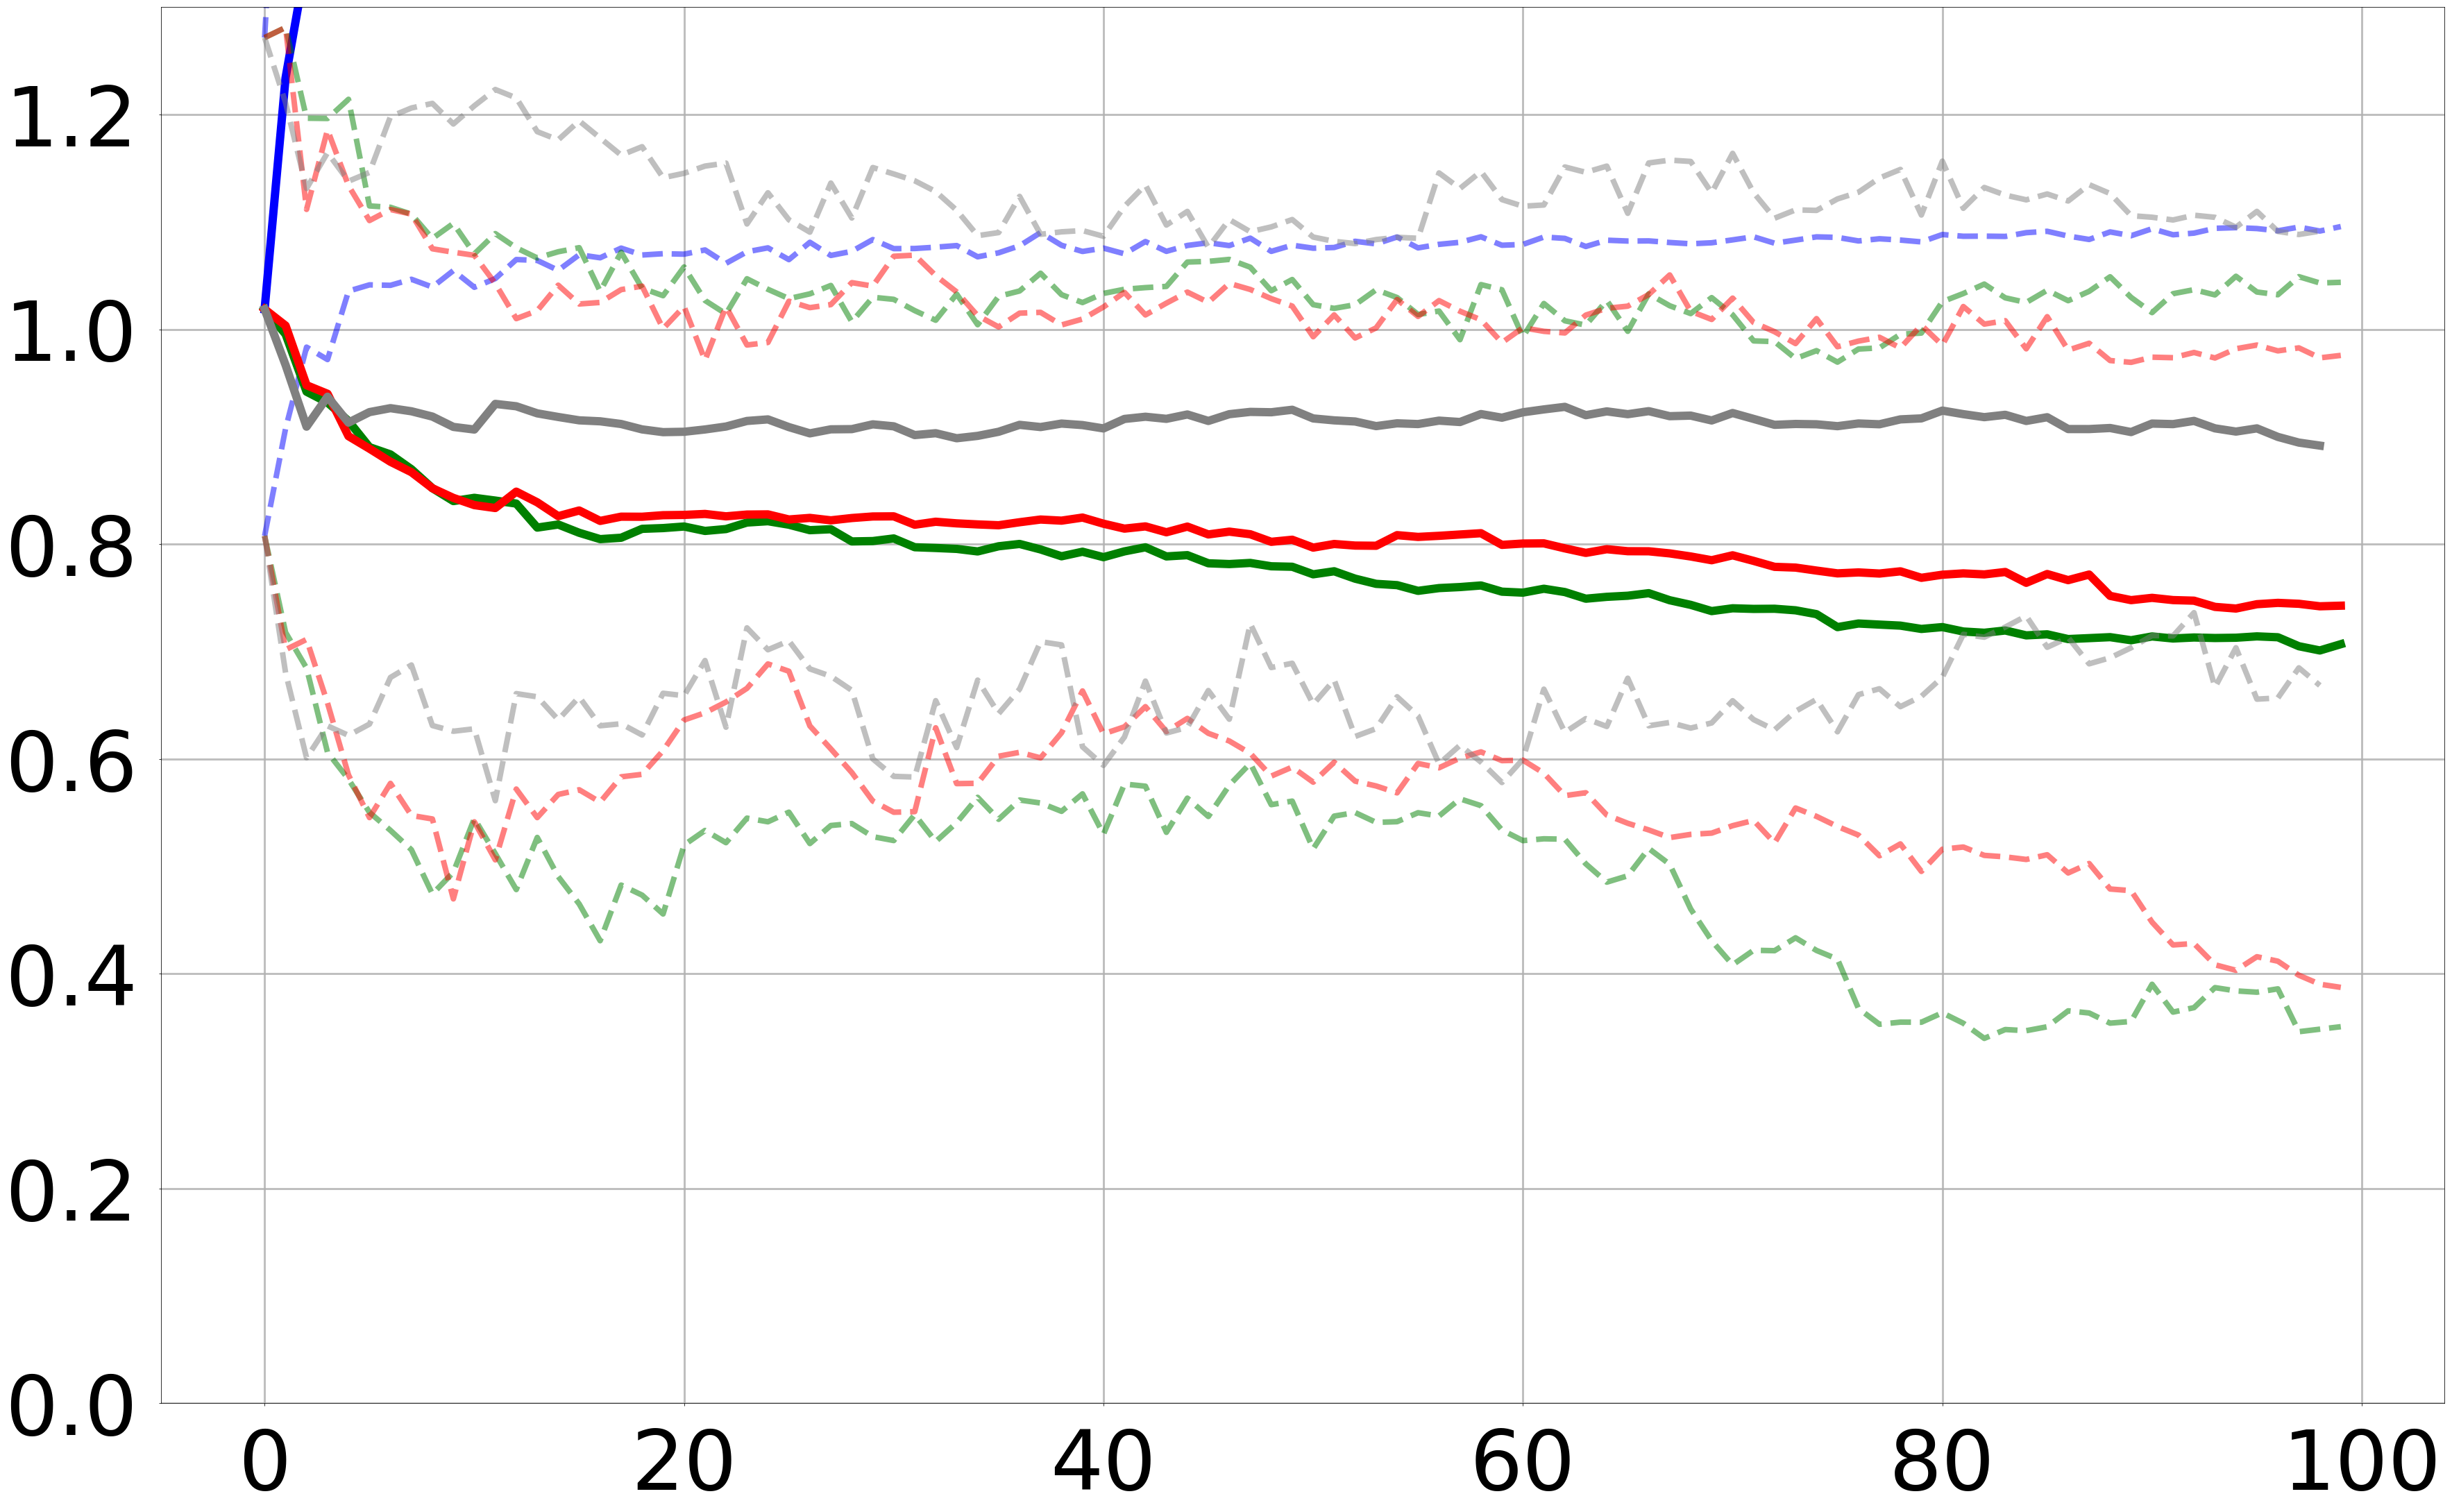

In [135]:

pp = PdfPages('performance_'+domain+'_with_mfgpucb.pdf')

clr_id = 0
LW_MEAN = 12
LW_Q =8
curve_labels = ['labelprop', 'gplapl', '5:1 mfgplapl corr=1.0', 'mf-gp-ucb corr=1.0']
plt.figure(figsize = (50, 30))

for algorithm in ['labelprop', 'gplapl', 'mfgplapl', 'mfgpucb']:
    lim = np.min([len(x) for x in lph_stats[algorithm]])
    plt.plot(range(lim), 
                         np.percentile([x[:lim] for x in lph_stats[algorithm]], 10, axis = 0), alpha = 0.5, color = clrs[clr_id], linestyle ='--', linewidth = LW_Q)
    plt.plot(range(lim), 
                         np.percentile([x[:lim] for x in lph_stats[algorithm]], 90, axis = 0), alpha = 0.5, color = clrs[clr_id], linestyle ='--', linewidth = LW_Q)

    plt.plot(np.mean([x[:lim] for x in lph_stats[algorithm]], axis = 0), color = clrs[clr_id], label = curve_labels[clr_id], linewidth = LW_MEAN)
    clr_id += 1



plt.tick_params(axis='both', which='major', labelsize=120)
plt.gca().grid(which='major', alpha=0.8, linewidth = 3)  
plt.ylim([0, 1.3])
#plt.savefig('performance_kdd_best_case.svg', format='svg', dpi=1000)

plt.tight_layout()
plt.gca().tick_params(axis='x', pad=30)
plt.gca().tick_params(axis='y', pad=30)
pp.savefig()
pp.close()

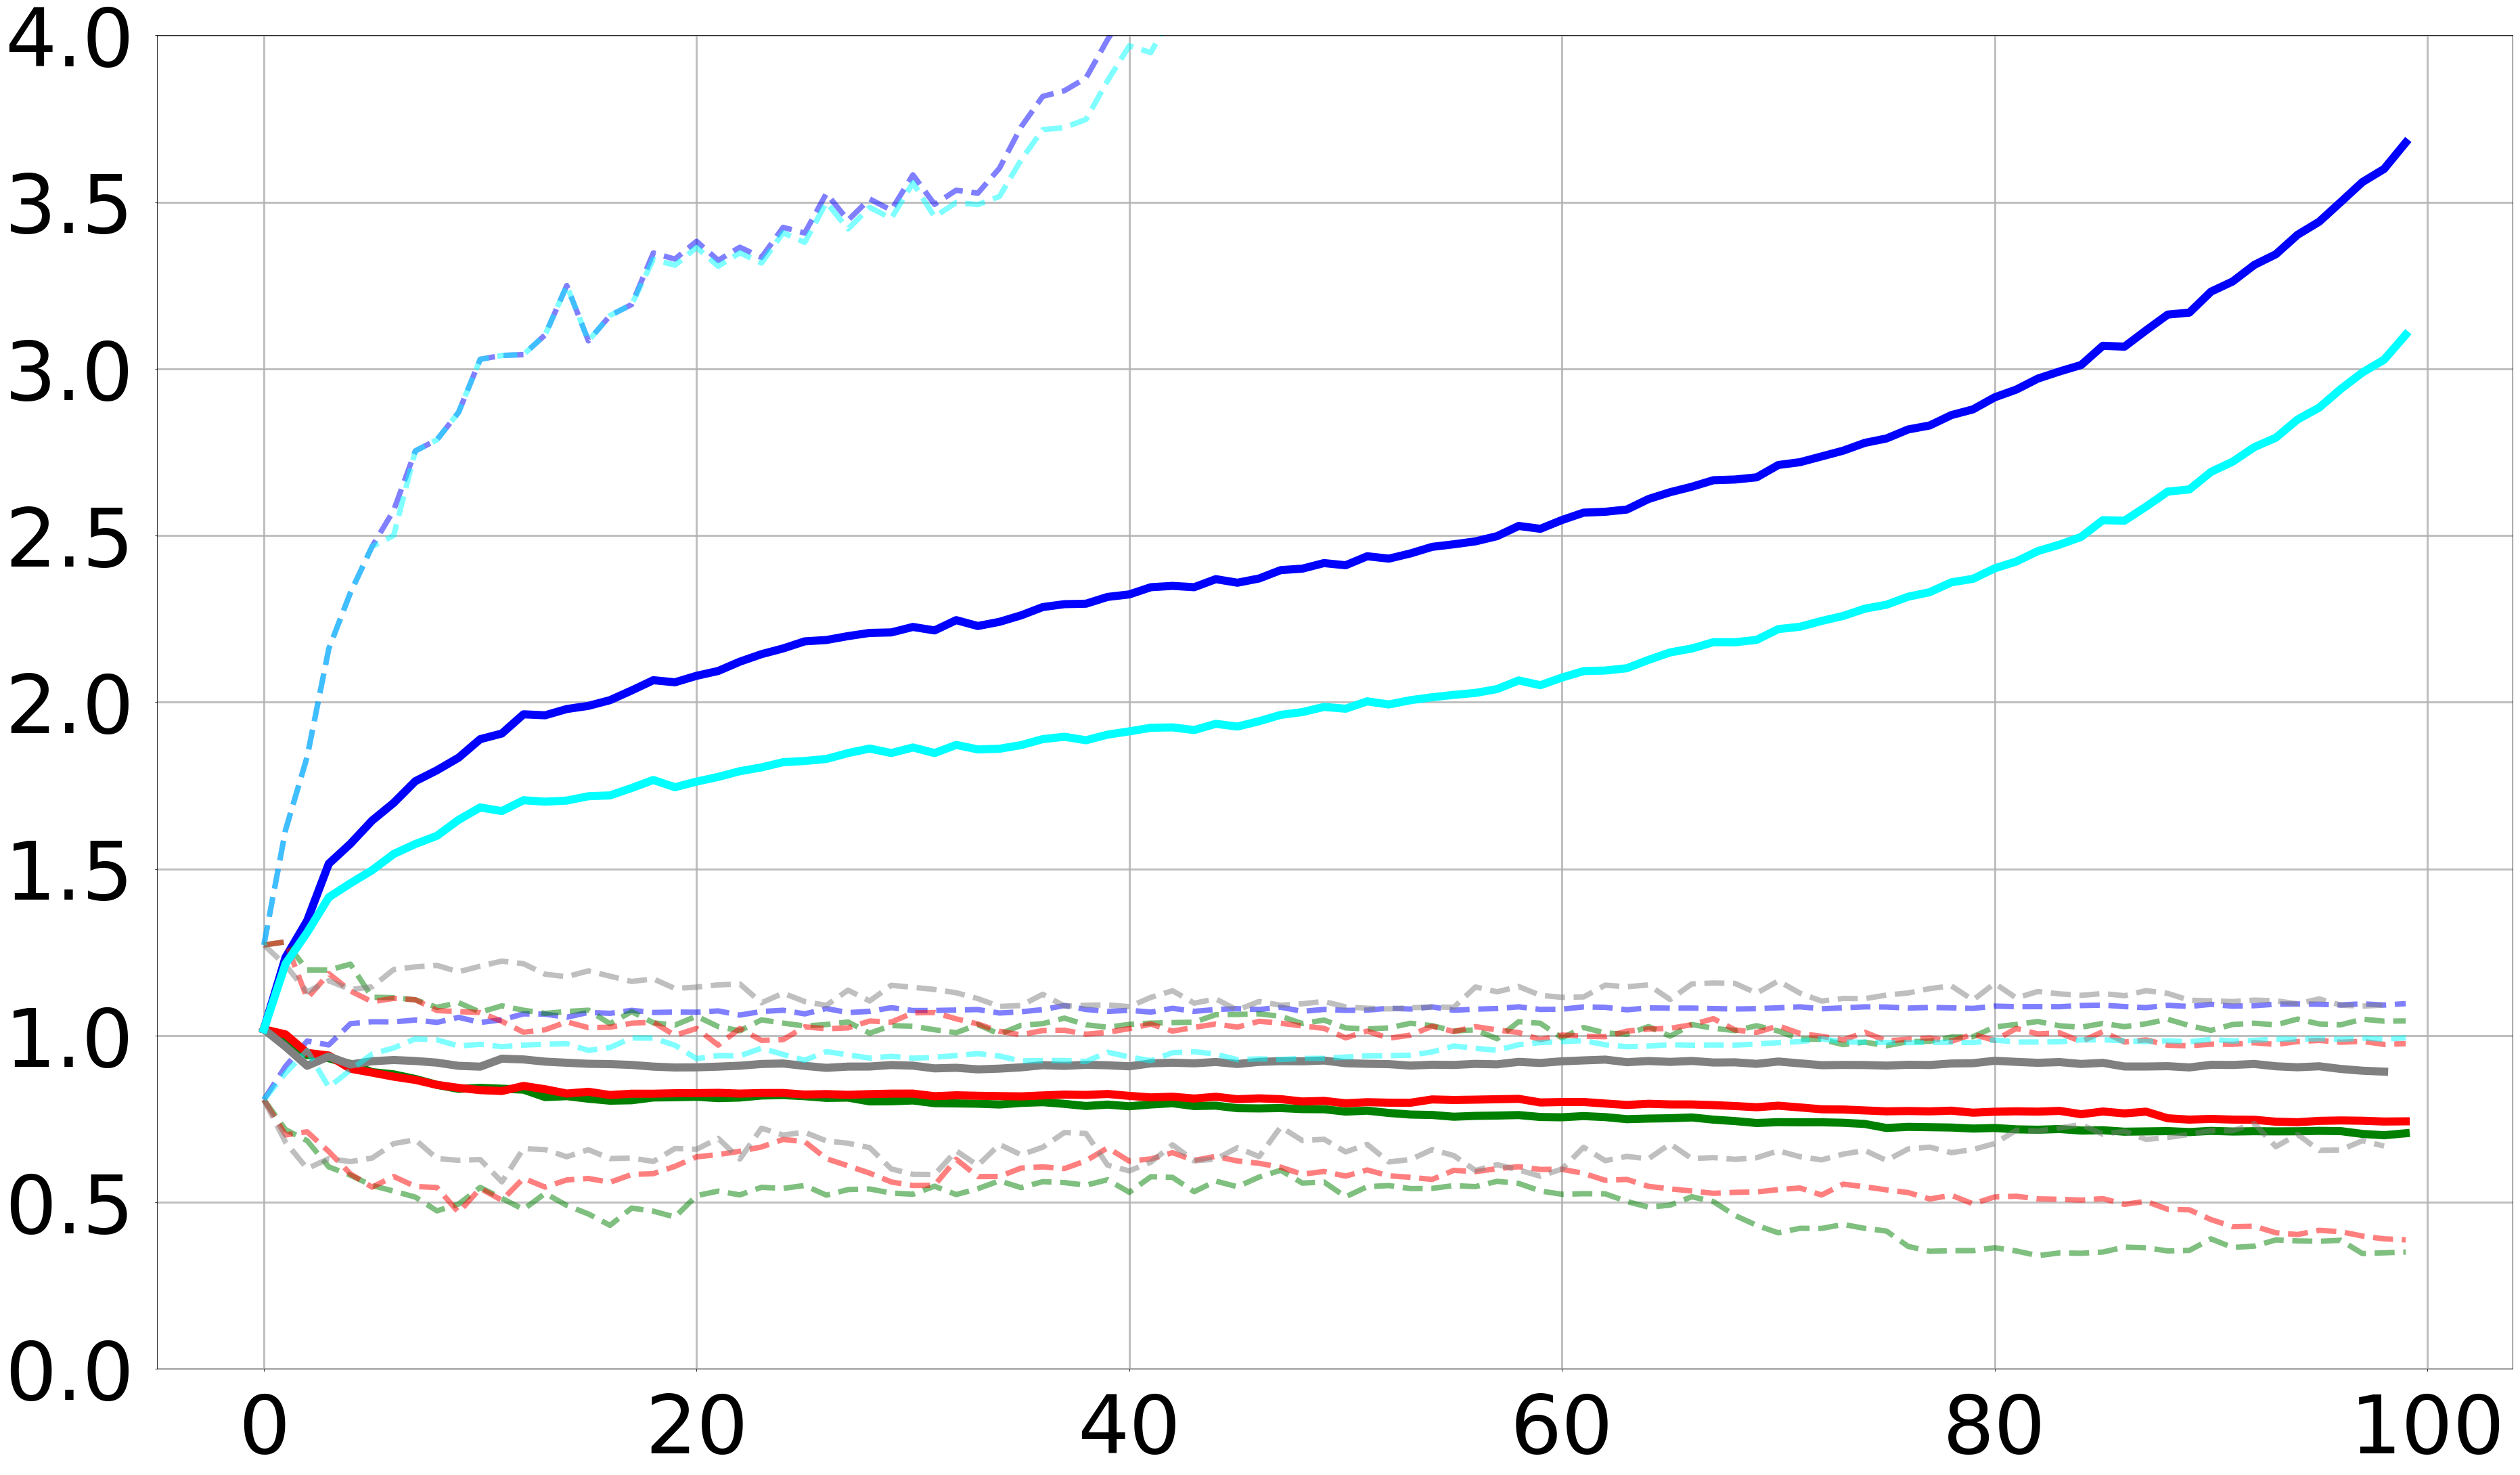

In [134]:

pp = PdfPages('performance_'+domain+'_with_mfgpucb_with_lfs.pdf')

clr_id = 0
LW_MEAN = 12
LW_Q =8
curve_labels = ['labelprop', 'gplapl', '5:1 mfgplapl corr=1.0', 'mf-gp-ucb corr=1.0',  'lfsmfgplapl']
plt.figure(figsize = (50, 30))

for algorithm in ['labelprop', 'gplapl', 'mfgplapl', 'mfgpucb',  'lfsmfgplapl']:
    lim = np.min([len(x) for x in lph_stats[algorithm]])
    plt.plot(range(lim), 
                         np.percentile([x[:lim] for x in lph_stats[algorithm]], 10, axis = 0), alpha = 0.5, color = clrs[clr_id], linestyle ='--', linewidth = LW_Q)
    plt.plot(range(lim), 
                         np.percentile([x[:lim] for x in lph_stats[algorithm]], 90, axis = 0), alpha = 0.5, color = clrs[clr_id], linestyle ='--', linewidth = LW_Q)

    plt.plot(np.mean([x[:lim] for x in lph_stats[algorithm]], axis = 0), color = clrs[clr_id], label = curve_labels[clr_id], linewidth = LW_MEAN)
    clr_id += 1



plt.tick_params(axis='both', which='major', labelsize=120)
plt.gca().grid(which='major', alpha=0.8, linewidth = 3)  
plt.ylim([0, 4])
#plt.savefig('performance_kdd_best_case.svg', format='svg', dpi=1000)

plt.tight_layout()
plt.gca().tick_params(axis='x', pad=30)
plt.gca().tick_params(axis='y', pad=30)
pp.savefig()
pp.close()